# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
----


## NeRF Dataset and Camera Geometry 

This notebook explains how NeRF datasets are structured and how camera parameters are used to generate rays.
The focus is on understanding **camera intrinsics, extrinsics, ray generation, and the NeRF 5D input** before training the model.

---

### 1. Dataset Overview

The NeRF example data contains two datasets:

```js
nerf_example_data/
├── nerf_synthetic/
│   ├── lego/
│   │   ├── train/
│   │   ├── val/
│   │   ├── test/
│   │   ├── transforms_train.json
│   │   ├── transforms_val.json
│   │   └── transforms_test.json
└── nerf_llff_data/
    ├── fern/
    ├── room/
    └── ...
```

* **nerf_synthetic**: computer-generated images rendered in Blender
* **nerf_llff_data**: real images captured with a camera

Each scene contains:

* RGB images
* Camera parameters required to generate rays

---

### 2. Understanding `transforms.json`

Each synthetic scene contains a JSON file like:

```json
{
  "camera_angle_x": 0.6911112070083618,
  "frames": [
    {
      "file_path": "train/r_0",
      "transform_matrix": [...]
    }
  ]
}
```

#### Meaning of fields

* `camera_angle_x`: horizontal field of view (FOV) in radians
* `file_path`: relative path to the image
* `transform_matrix`: 4×4 camera-to-world transformation matrix

---

### 4. Camera Intrinsics: `camera_angle_x`

Camera intrinsics describe how a camera converts 3D rays into 2D image pixels.

#### 4.1 What is `camera_angle_x`?
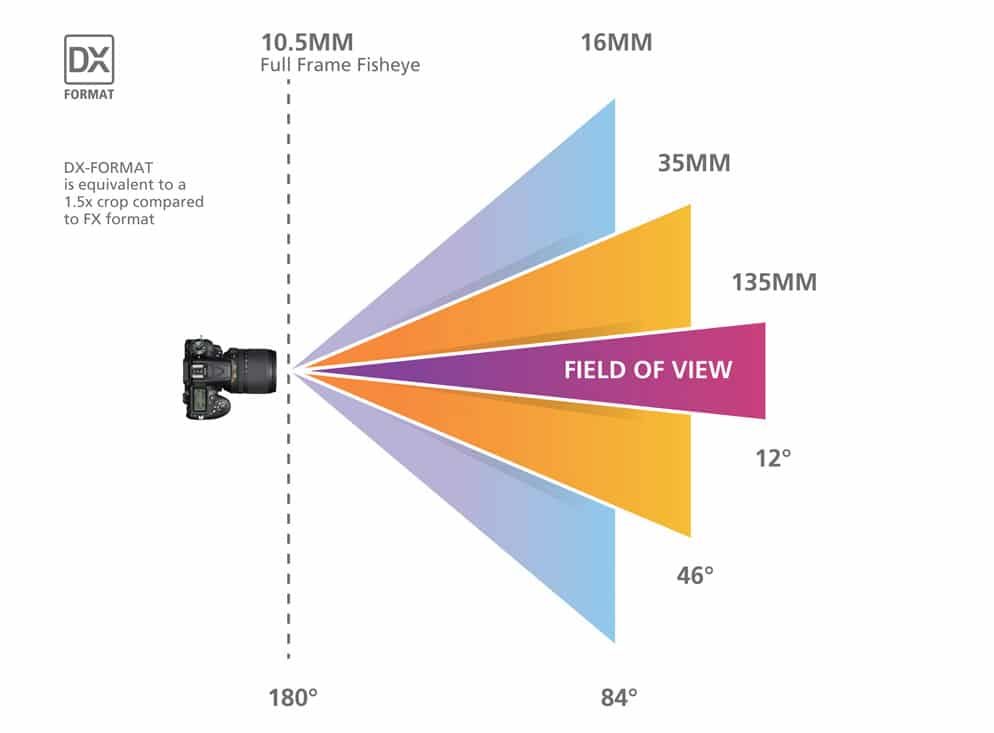

$$
\alpha = \text{camera\_angle\_x}
$$

This value represents the **horizontal field of view** of the camera.


#### 4.2 Computing the Focal Length

Let:

* $W$ = image width in pixels
* $\alpha$ = horizontal field of view

The focal length $f$ is computed as:

$$
f = \frac{0.5 \cdot W}{\tan(\alpha / 2)}
$$


#### 4.3 Principal Point Assumption

NeRF assumes:

* Square pixels
* Principal point at image center

$$
c_x = \frac{W}{2}, \quad c_y = \frac{H}{2}
$$


#### 4.4 What is the K Matrix?

The **K matrix** is the **camera intrinsic matrix**.
It converts camera-space rays into pixel coordinates.

It is defined as:

$$
K =
\begin{bmatrix}
f & 0 & c_x \\
0 & f & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

##### Meaning of each term

* $f$: focal length (controls zoom / FOV)
* $(c_x, c_y)$: principal point (image center)

##### Why K is important

* It maps pixels → camera rays
* Without $K$, rays cannot be generated
* NeRF needs $K$ to convert every pixel into a 3D ray


---

### 5. Camera Extrinsics: `transform_matrix`

The `transform_matrix` is a **camera-to-world (c2w)** matrix:

$$
T_{c2w} =
\begin{bmatrix}
R & t \\
0 & 1
\end{bmatrix}
$$

Where:

* $R$: camera orientation (rotation)
* $t$: camera position (translation)

This matrix places the camera in the world coordinate system.

---


### 6. Ray Generation in NeRF 

NeRF renders images by casting **one ray per pixel** from the camera into the 3D scene.
Each ray is used to sample points in space, which are then evaluated by the NeRF network.


#### 6.1 Pixel to Camera-Space Ray

For a pixel located at image coordinates $(u, v)$, we first compute a ray direction in the **camera coordinate system**.

Let:

* $(c_x, c_y)$ be the image center
* $f$ be the focal length

The camera-space ray direction is:

$$
\mathbf{d}_{cam} =
\begin{bmatrix}
(u - c_x)/f \\
(v - c_y)/f \\
-1
\end{bmatrix}
$$

**Explanation:**

* $(u - c_x)$ and $(v - c_y)$ shift the pixel origin to the image center
* Dividing by $f$ accounts for camera focal length
* $-1$ indicates the ray points forward from the camera

This vector defines **which direction the pixel looks in camera space**.


#### 6.2 Camera-Space to World-Space Ray

The ray direction computed above is in the **camera coordinate frame**.
To place it in the 3D scene, we rotate it using the camera rotation matrix $R$:

$$
\mathbf{d}_{world} = R \cdot \mathbf{d}_{cam}
$$

The ray origin is the camera position:

$$
\mathbf{o} = t
$$

where $t$ is the translation vector from the camera-to-world matrix.


#### 6.3 Ray Equation

Each ray is represented parametrically as:

$$
\mathbf{r}(t) = \mathbf{o} + t\mathbf{d}
$$

**Meaning:**

* $\mathbf{o}$: where the ray starts (camera position)
* $\mathbf{d}$: direction of the ray
* $t$: distance along the ray

---

### 7. Sampling Points Along a Ray

NeRF does not evaluate the scene continuously.
Instead, it **samples discrete points** along each ray.

Given near and far bounds $(t_n, t_f)$, points are sampled as:

$$
\mathbf{p}(t_i) = \mathbf{o} + t_i \mathbf{d}
$$

where $t_i \in [t_n, t_f]$.

**Explanation:**

* Points closer to the camera capture foreground geometry
* Points farther capture background geometry
* Multiple samples allow NeRF to approximate volume rendering

---

### 8. From Ray Direction to Viewing Direction $(\theta, \phi)$
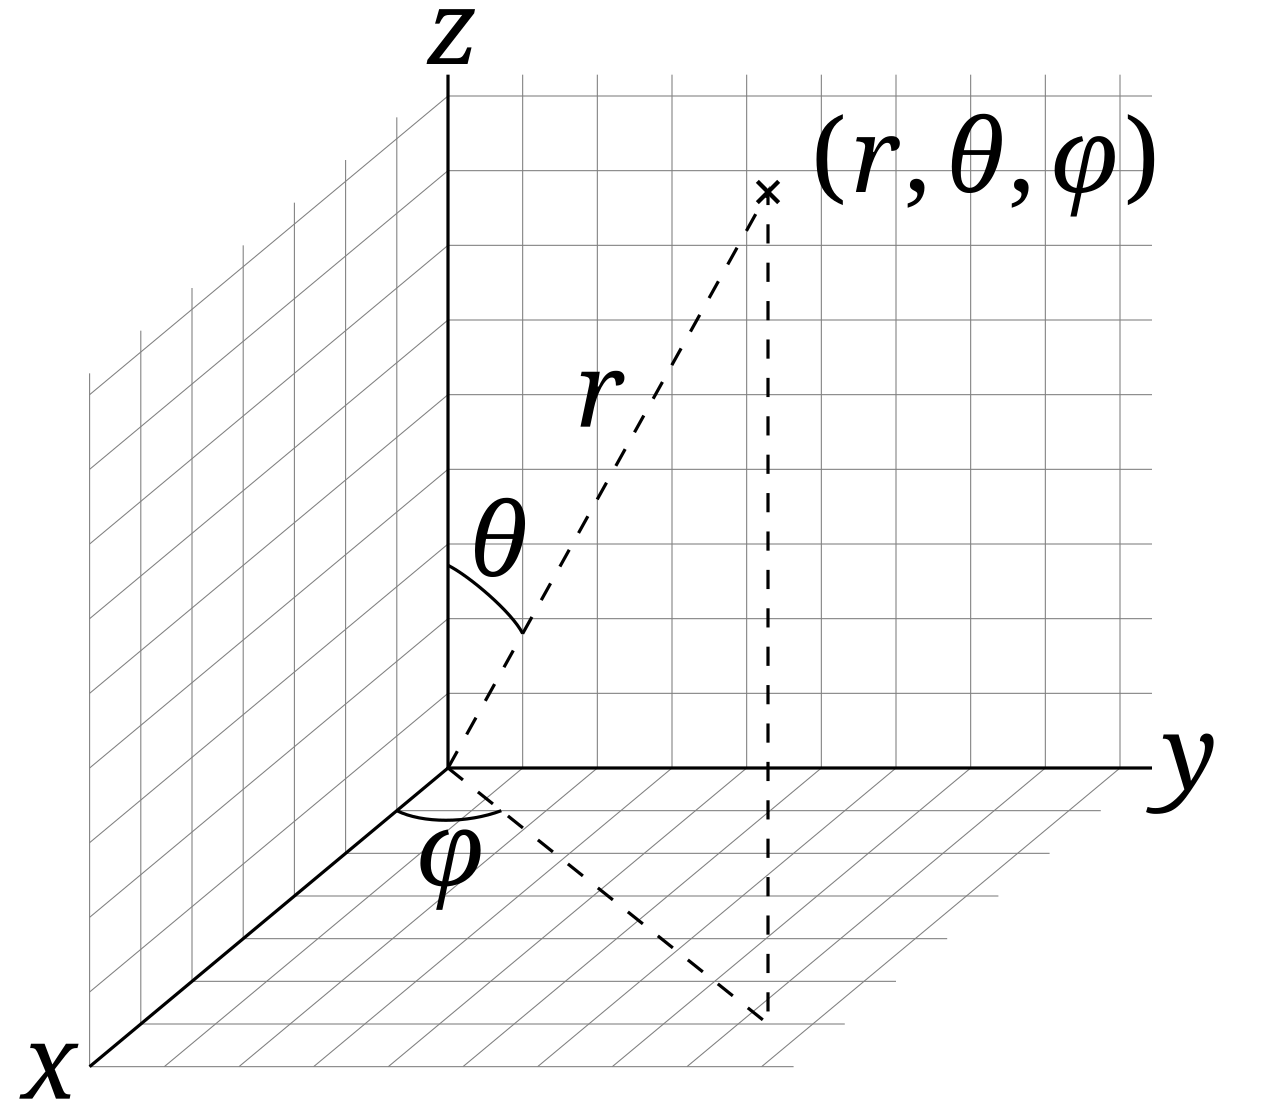

NeRF models view-dependent appearance, so it needs to know **from which direction a point is viewed**.

This viewing direction comes from the **ray direction vector**.

Given a normalized ray direction:

$$
(d_x, d_y, d_z)
$$

the angles are defined as:

### Polar angle

$$
\theta = \arccos(d_z)
$$

### Azimuth angle

$$
\phi = \arctan2(d_y, d_x)
$$

Unlike arctan(y/x), arctan2:

* Knows the sign of both x and y
* Distinguishes left/right, up/down
* Avoids division-by-zero problems

**Interpretation:**

* $\theta$ describes how much the ray tilts away from the vertical axis
* $\phi$ describes the horizontal orientation of the ray

---

## 9. End-to-End Ray Processing Summary

```text
Pixel (u, v)
↓
Camera intrinsics (K)
↓
Camera-space ray
↓
Camera extrinsics (R, t)
↓
World-space ray
↓
Sample points along ray
↓
(x, y, z, direction)
↓
NeRF → color + density
```

---
